In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import pandas as pd
import random
import torch.nn.functional as F
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

# Classes

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class PatchDataset(Dataset):
    def __init__(self, X, y, augment=False, minority_class=1):
        self.X = X
        self.y = y
        self.augment = augment
        self.minority_class = minority_class
        
        # Define transforms
        self.minority_transform = minority_transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
        ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # (256,256,8)
        y = self.y[idx]

        # if self.augment:
        #     if y == self.minority_class:
        #         x = self.minority_transform(image=x)["image"]

        # Convert to tensor and move channels first (C,H,W)
        x = torch.from_numpy(x).permute(2, 0, 1)  # (8,256,256)

        return x.float(), torch.tensor(y, dtype=torch.long)

In [44]:
class CNN(nn.Module):
    def __init__(self, num_classes=2, in_channels=8, log_features=False):
        super(CNN, self).__init__()
        self.log_features = log_features

        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups=8, num_channels=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups=8, num_channels=64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.gn3 = nn.GroupNorm(num_groups=8, num_channels=128)

        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=0.2)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.gn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        if self.log_features:
            print("Block 1:", x.shape, x.mean().item(), x.std().item())

        # Block 2
        x = self.conv2(x)
        x = self.gn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        if self.log_features:
            print("Block 2:", x.shape, x.mean().item(), x.std().item())

        # Block 3
        x = self.conv3(x)
        x = self.gn3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        if self.log_features:
            print("Block 3:", x.shape, x.mean().item(), x.std().item())

        # Classifier
        x = self.classifier(x)
        if self.log_features:
            print("Classifier output:", x.shape)

        return x

# Dataset preparation

In [5]:
# Load patches
patches = np.load("/home/ubuntu/mucilage_pipeline/patches.npy")  # shape (1643, 256, 256, 8)

# Load labels CSV
labels_df = pd.read_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/src/labels_corrected.csv")
labels_df = labels_df[~labels_df['label'].isin(['algae'])]

# Map string labels to integers
label_mapping = {
    "clean_water": 0,
    "mucilage": 1
}
labels_df["label_id"] = labels_df["label"].map(label_mapping)

# Subset patches based on indices in CSV
selected_indices = labels_df["index"].values
X = patches[selected_indices][:,:,:,:7]   # shape (N, 256,256,7)
y = labels_df["label_id"].values  # shape (N,)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (797, 256, 256, 7)
y shape: (797,)


Patches with NaNs: [266 288 290 780 788]


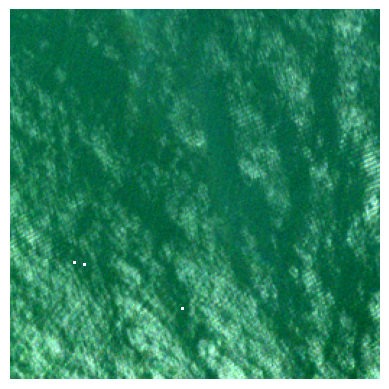

In [6]:
# Nan

nan_patches = np.where(np.isnan(X).any(axis=(1,2,3)))[0]
print("Patches with NaNs:", nan_patches)

def show_rgb(patch):
    """Visualize patch with stretch in RGB (B4,B3,B2)."""
    rgb = patch[:, :, [2,1,0]]
    p2, p98 = np.nanpercentile(rgb, (2, 98))
    rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)
    plt.imshow(rgb)
    plt.axis("off")

show_rgb(X[788])

In [7]:
# Drop Nan patches

keep_mask = np.ones(len(X), dtype=bool)
keep_mask[nan_patches] = False

X = X[keep_mask]
y = y[keep_mask]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (792, 256, 256, 7)
y shape: (792,)


In [8]:
# Replace NaNs and Infs with 0
#X = np.nan_to_num(X, nan=0.0)

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

# Normalize
mean = np.nanmean(X_train, axis=(0,1,2))  # mean per band
std  = np.nanstd(X_train, axis=(0,1,2))   # std per band
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

# # Check for NaNs
# assert not np.isnan(X_train).any(), "NaNs found in training data"
# assert not np.isnan(X_val).any(), "NaNs found in validation data"

In [9]:
# Count samples for each class
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(array([0, 1]), array([470,  84]))
(array([0, 1]), array([202,  36]))


In [10]:
train_dataset = PatchDataset(X_train, y_train, augment=True)
val_dataset   = PatchDataset(X_val, y_val, augment=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Training and Validation

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(np.unique(y_train))
model = CNN(num_classes=num_classes, in_channels=7, log_features=False).to(device)

# Compute class weights
class_counts = np.bincount(y_train)
weights = 1.0 / class_counts
weights = torch.tensor(weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0003)



num_epochs=10
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    
    # Train
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0
    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        data, targets = data.to(device), targets.to(device)
        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # accumulate stats
        batch_size = targets.size(0)
        running_loss_train += loss.item() * batch_size

        _, preds = torch.max(scores, 1)
        correct_train += (preds == targets).sum().item()
        total_train += batch_size

    # Evaluate
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                batch_size = targets.size(0)

                scores = model(data)
                loss = criterion(scores, targets)

                running_val_loss += loss.item() * batch_size
                _, preds = torch.max(scores, 1)
                correct_val += (preds == targets).sum().item()
                total_val += batch_size

    # Compute epoch-level metrics
    train_epoch_loss = running_loss_train / total_train
    train_losses.append(train_epoch_loss)
    train_epoch_acc = correct_train / total_train
    print(f"Train Loss: {train_epoch_loss:.4f}, Accuracy: {train_epoch_acc:.4f}")

    val_epoch_loss = running_val_loss / total_val
    valid_losses.append(val_epoch_loss)
    val_epoch_acc = correct_val / total_val
    print(f"Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}")

Epoch [1/10]


100%|██████████| 9/9 [00:51<00:00,  5.72s/it]


Train Loss: 0.6509, Accuracy: 0.6083
Validation Loss: 0.6177, Accuracy: 0.5000
Epoch [2/10]


100%|██████████| 9/9 [00:49<00:00,  5.55s/it]


Train Loss: 0.5769, Accuracy: 0.5975
Validation Loss: 0.6008, Accuracy: 0.6975
Epoch [3/10]


100%|██████████| 9/9 [00:50<00:00,  5.63s/it]


Train Loss: 0.5681, Accuracy: 0.6552
Validation Loss: 0.5522, Accuracy: 0.6345
Epoch [4/10]


100%|██████████| 9/9 [00:50<00:00,  5.66s/it]


Train Loss: 0.5410, Accuracy: 0.7599
Validation Loss: 0.5666, Accuracy: 0.7101
Epoch [5/10]


100%|██████████| 9/9 [00:51<00:00,  5.70s/it]


Train Loss: 0.5104, Accuracy: 0.7166
Validation Loss: 0.5293, Accuracy: 0.7605
Epoch [6/10]


100%|██████████| 9/9 [00:51<00:00,  5.71s/it]


Train Loss: 0.4950, Accuracy: 0.6986
Validation Loss: 0.5755, Accuracy: 0.8025
Epoch [7/10]


100%|██████████| 9/9 [00:50<00:00,  5.59s/it]


Train Loss: 0.4969, Accuracy: 0.7888
Validation Loss: 0.5096, Accuracy: 0.7143
Epoch [8/10]


100%|██████████| 9/9 [00:51<00:00,  5.74s/it]


Train Loss: 0.4582, Accuracy: 0.8195
Validation Loss: 0.5010, Accuracy: 0.7437
Epoch [9/10]


100%|██████████| 9/9 [00:51<00:00,  5.77s/it]


Train Loss: 0.4417, Accuracy: 0.7491
Validation Loss: 0.5311, Accuracy: 0.8151
Epoch [10/10]


100%|██████████| 9/9 [00:56<00:00,  6.22s/it]


Train Loss: 0.4370, Accuracy: 0.7834
Validation Loss: 0.4835, Accuracy: 0.7983


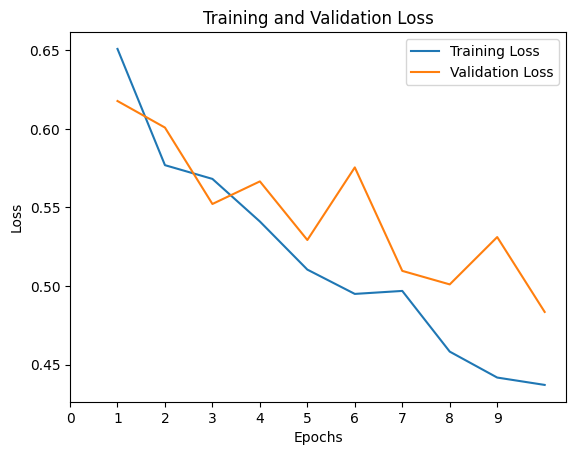

In [46]:
epochs = range(1, num_epochs + 1)

# Plot and label the training and validation loss values
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, len(epochs), 1))
 
# Display the plot
plt.legend(loc='best')
plt.show()

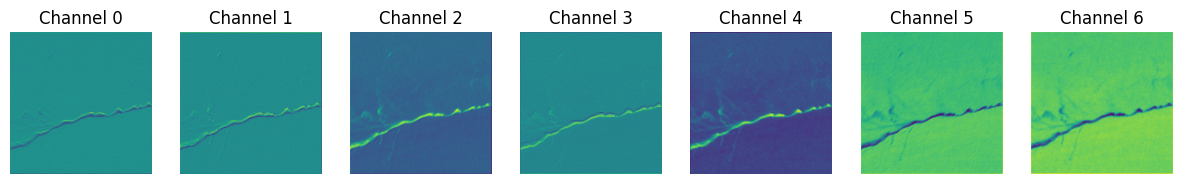

In [42]:
def visualize_feature_maps(model, x, layer_name="conv1"):
    """Visualize feature maps from a given layer"""
    feature_maps = None

    def hook_fn(module, input, output):
        nonlocal feature_maps
        feature_maps = output.detach().cpu()

    # Register hook
    hook = dict(model.named_modules())[layer_name].register_forward_hook(hook_fn)

    # Forward pass
    _ = model(x.unsqueeze(0))  # add batch dim

    # Remove hook
    hook.remove()

    # Plot first 6 feature maps
    fig, axes = plt.subplots(1, 7, figsize=(15, 5))
    for i in range(7):
        axes[i].imshow(feature_maps[0, i].numpy(), cmap="viridis")
        axes[i].axis("off")
        axes[i].set_title(f"Channel {i}")
    plt.show()

sample_x = X[10] 
sample_x = torch.from_numpy(sample_x).permute(2, 0, 1).float()
visualize_feature_maps(model, sample_x, layer_name="conv1")

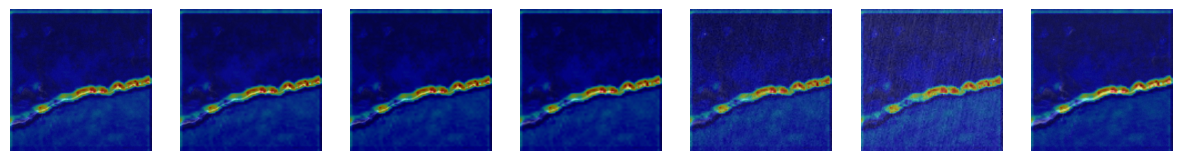

In [43]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layer = model.conv3  # last conv block

cam = GradCAM(model=model, target_layers=[target_layer])
input_tensor = sample_x.unsqueeze(0)
grayscale_cam = cam(input_tensor=input_tensor)[0, :]

fig, axes = plt.subplots(1, 7, figsize=(15, 5))
for i in range(7):
    band = sample_x[i].cpu().numpy()  # first band
    band = (band - band.min()) / (band.max() - band.min())
    axes[i].imshow(band, cmap="gray")
    axes[i].imshow(grayscale_cam, cmap="jet", alpha=0.5)  # overlay
    axes[i].axis("off")
plt.show()